# Playing around with spaCy
[spaCy](https://honnibal.github.io/spaCy/quickstart.html)

Using the basic introduction to spaCy, then playting with it. Let's load spaCy's english dictionary.

In [101]:
from __future__ import unicode_literals # If Python 2
import spacy.en
from spacy.tokens import Token
from spacy.parts_of_speech import ADV

nlp = spacy.en.English()

# Find log probability of Nth most frequent word
probs = [lex.prob for lex in nlp.vocab]
probs.sort()
words = [w for w in nlp.vocab if w.has_repvec]

spaCy tokenizes words, then treats each token as a Token object. Each token has an integer and string representation. Each token also has things like:

* **orth**
  * The form of the word with no string normalization or processing, as it appears in the string, without trailing whitespace. i.e. " Frank " -> "frank"
* **head**
  * The Token that is the immediate syntactic head of the word. If the word is the root of the dependency tree, the same word is returned.
* **lemma**
  * The “base” of the word, with no inflectional suffixes, e.g. the lemma of “developing” is “develop”, the lemma of “geese” is “goose”, etc. Note that derivational suffixes are not stripped, e.g. the lemma of “instutitions” is “institution”, not “institute”. Lemmatization is performed using the WordNet data, but extended to also cover closed-class words such as pronouns. By default, the WN lemmatizer returns “hi” as the lemma of “his”. We assign pronouns the lemma -PRON-.
* **prob**
  * The unigram log-probability of the word, estimated from counts from a large corpus, smoothed using Simple Good Turing estimation.
* **cluster**
  * The Brown cluster ID of the word. These are often useful features for linear models. If you’re using a non-linear model, particularly a neural net or random forest, consider using the real-valued word representation vector, in Token.repvec, instead.
* **repvec**
  * A “word embedding” representation: a dense real-valued vector that supports similarity queries between words. By default, spaCy currently loads vectors produced by the Levy and Goldberg (2014) dependency-based word2vec model.
 

In [143]:
tokens = nlp(u'"I ran to the wall quickly," Frank explained to the robot.')
ran = tokens[2]
quickly = tokens[6]
run = nlp(moved.lemma_)[0]

# the integer and string representations of "moved" and its head
print (ran.orth, ran.orth_, ran.head.lemma, ran.head.lemma_)
print (quickly.orth, quickly.orth_, quickly.lemma, quickly.lemma_,)
print (quickly.head.orth_, quickly.head.lemma_)
print (ran.prob, run.prob, quickly.prob)
print (ran.cluster, run.cluster, quickly.cluster)

(1462, u'ran', 3944, u'explain')
(1737, u'quickly', 1737, u'quickly')
(u'ran', u'run')
(-9.612654685974121, -8.054361343383789, -9.300590515136719)
(170, 437, 16106)


Given a test sentence (in this case: **"I ran to the wall quickly," Frank explained to the robot.**), we can highlight parts of speech (i.e. adverbs):

In [146]:
is_adverb = lambda tok: tok.pos == ADV and tok.prob < probs[-1000]
str_ = u'"I ran to the wall quickly," Frank explained to the robot.'
tokens = nlp(str_)
print u''.join(tok.string.upper() if is_adverb(tok) else tok.string for tok in tokens)
quickly = tokens[6]

"I ran to the wall QUICKLY," Frank explained to the robot.


Find similar words to 'quickly' via [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity):

In [99]:
from numpy import dot
from numpy.linalg import norm

cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2))
words.sort(key=lambda w: cosine(w.repvec, quickly.repvec))
words.reverse()

print('1-20:')
print('\n'.join(w.orth_ for w in words[0:20]))
print('\n50-60:')
print('\n'.join(w.orth_ for w in words[50:60]))
print('\n100-110:')
print('\n'.join(w.orth_ for w in words[100:110]))
print('\n1000-1010:')
print('\n'.join(w.orth_ for w in words[1000:1010]))
print('\n50000-50010:')
print('\n'.join(w.orth_ for w in words[50000:50010])) 

1-20:
quickly
Quickly
QUICKLY
rapidly
Rapidly
swiftly
Swiftly
promptly
Promptly
gracefully
amicably
expeditiously
painlessly
forcefully
effortlessly
Effortlessly
precipitously
spontaneously
stealthily
impulsively

50-60:
instantaneously
skilfully
unwillingly
clumsily
erratically
definitively
tactfully
Tactfully
maturely
irreversibly

100-110:
Prudently
greedily
furiously
mysteriously
unobtrusively
courteously
serendipitously
Serendipitously
innocently
triumphantly

1000-1010:
thirdly
unashamedly
fashionably
palpably
Thankfully
thankfully
tragically
Tragically
provisionally
spatially

50000-50010:
Mathiesen
Jagat
enthusiasms
bloomers
Bloomers
condone
nucleic
Nucleic
Yomiuri
Lestat


We can focus on one meaning of *quickly* and find similar words if we average over related words:

In [98]:
say_adverbs = ['quickly', 'swiftly', 'speedily', 'rapidly']
say_vector = sum(nlp.vocab[adverb].repvec for adverb in say_adverbs) / len(say_adverbs)
words.sort(key=lambda w: cosine(w.repvec, say_vector))
words.reverse()
print('1-20:')
print('\n'.join(w.orth_ for w in words[0:20]))
print('\n50-60:')
print('\n'.join(w.orth_ for w in words[50:60]))
print('\n1000-1010:')
print('\n'.join(w.orth_ for w in words[1000:1010]))


1-20:
Swiftly
swiftly
QUICKLY
Quickly
quickly
Rapidly
rapidly
Promptly
promptly
gracefully
forcefully
amicably
expeditiously
painlessly
Effortlessly
effortlessly
precipitously
stealthily
hurriedly
Methodically

50-60:
noisily
impulsively
Inexorably
inexorably
peaceably
recklessly
chaotically
Unilaterally
unilaterally
Cautiously

1000-1010:
demographically
graphically
Intermittently
intermittently
Frustratingly
frustratingly
Brightly
brightly
blatantly
Philosophically


Let's look at other parts of speech from our original sentence:

In [123]:
from spacy.parts_of_speech import NOUN

is_noun = lambda tok: tok.pos == NOUN and tok.prob < probs[-1000]
print u''.join(tok.string.upper() if is_noun(tok) else tok.string for tok in tokens)
nouns = [tok for tok in tokens if is_noun(tok)]

"I ran to the WALL quickly," FRANK explained to the ROBOT.


How closely does one test noun match each noun found in our sentence? That is, if we say, "barrier", is it closer to "wall," "Frank", or "robot"? How about "car" or "agent"?

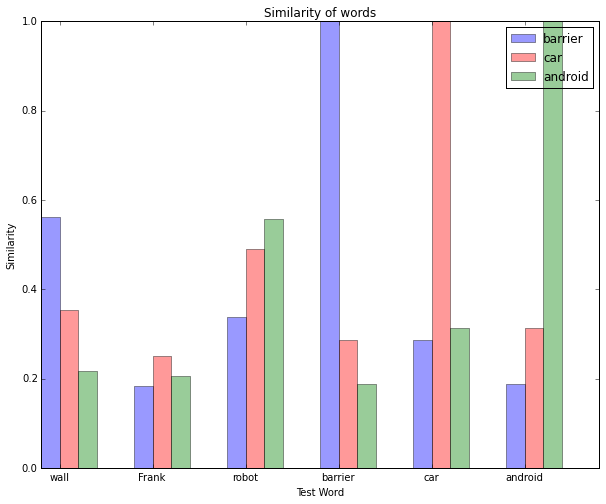

In [152]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

barrier = nlp('barrier')[0]
car = nlp('car')[0]
agent = nlp('android')[0]
test_nouns = nouns + [barrier] + [car] + [agent]

n = len(test_nouns)
barrier_relations = np.zeros(n)
car_relations = np.zeros(n)
agent_relations = np.zeros(n)
for i, noun in enumerate(test_nouns):
    barrier_relations[i] = cosine(barrier.repvec, noun.repvec)
    car_relations[i] = cosine(car.repvec, noun.repvec) 
    agent_relations[i] = cosine(agent.repvec, noun.repvec) 


fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n)
bar_width = 0.2

opacity = 0.4

rects1 = plt.bar(index, barrier_relations, bar_width,
                 alpha=opacity,
                 color='b',
                 label=barrier.orth_)

rects2 = plt.bar(index + bar_width, car_relations, bar_width,
                 alpha=opacity,
                 color='r',
                 label=car.orth_)

rects3 = plt.bar(index + 2 * bar_width, agent_relations, bar_width,
                 alpha=opacity,
                 color='g',
                 label=agent.orth_)

labels = [tok.orth_ for tok in test_nouns]

plt.xlabel('Test Word')
plt.ylabel('Similarity')
plt.title('Similarity of words')
plt.xticks(index + bar_width, labels)
plt.legend()

In [1]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
